In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix


In [2]:
img_size = (224, 224)
batch_size = 32
seed = 42

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    './images',                 # ✅ 현재 노트북 기준 상대경로
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=seed
)

val_generator = datagen.flow_from_directory(
    './images',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=seed
)

class_names = list(train_generator.class_indices.keys())
print(f"[🔤] Classes: {class_names}")


Found 864 images belonging to 36 classes.
Found 180 images belonging to 36 classes.
[🔤] Classes: ['apple', 'banana', 'beetroot', 'bell pepper', 'cabbage', 'capsicum', 'carrot', 'cauliflower', 'chilli pepper', 'corn', 'cucumber', 'eggplant', 'garlic', 'ginger', 'grapes', 'jalapeno', 'kiwi', 'lemon', 'lettuce', 'mango', 'onion', 'orange', 'papaya', 'passion fruit', 'pear', 'peas', 'pineapple', 'pomegranate', 'potato', 'raddish', 'soy beans', 'spinach', 'sweet potato', 'tomato', 'turnip', 'watermelon']


In [3]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # 💡 처음엔 동결 (fine-tuning은 나중에)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,426,596 (9.26 MB)

 Trainable params: 168,612 (658.64 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [4]:
from PIL import Image, UnidentifiedImageError

import os

def clean_corrupt_images(root_dir="./images"):
    broken = []
    for cls in os.listdir(root_dir):
        cls_path = os.path.join(root_dir, cls)
        if not os.path.isdir(cls_path): continue
        
        for fname in os.listdir(cls_path):
            fpath = os.path.join(cls_path, fname)
            try:
                with Image.open(fpath) as img:
                    img.verify()  # 이미지를 검증만 하고 닫음
            except (UnidentifiedImageError, OSError):
                print(f"[💥] 삭제: {fpath}")
                os.remove(fpath)
                broken.append(fpath)
    print(f"[🧼] 삭제 완료: 총 {len(broken)}장")

clean_corrupt_images()

[🧼] 삭제 완료: 총 0장


In [5]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
]

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=callbacks
)

C:\Users\ghwns\anaconda3\envs\tf_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
C:\Users\ghwns\anaconda3\envs\tf_env\lib\site-packages\PIL\Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 29s 726ms/step - accuracy: 0.0529 - loss: 3.6836 - val_accuracy: 0.1444 - val_loss: 3.2809 - learning_rate: 5.0000e-04
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 514ms/step - accuracy: 0.3384 - loss: 2.7767 - val_accuracy: 0.2278 - val_loss: 2.8723 - learning_rate: 5.0000e-04
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 17s 626ms/step - accuracy: 0.5276 - loss: 2.0610 - val_accuracy: 0.3167 - val_loss: 2.6102 - learning_rate: 5.0000e-04
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 18s 514ms/step - accuracy: 0.6565 - loss: 1.5899 - val_accuracy: 0.3389 - val_loss: 2.4642 - learning_rate: 5.0000e-04
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 518ms/step - accuracy: 0.7989 - loss: 1.1695 - val_accuracy: 0.3889 - val_loss: 2.3722 - learning_rate: 5.0000e-04
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 515ms/step - accuracy: 0.8404 - loss: 0.8956 - val_accuracy: 0.4000 - val_loss: 2.3388 - learning_rate: 5.0000e-04
Epoch 7/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 513ms/step - acc

6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 781ms/step
               precision    recall  f1-score   support

        apple       0.75      0.60      0.67         5
       banana       0.80      0.80      0.80         5
     beetroot       0.29      0.40      0.33         5
  bell pepper       0.17      0.20      0.18         5
      cabbage       0.50      0.20      0.29         5
     capsicum       0.33      0.20      0.25         5
       carrot       0.60      0.60      0.60         5
  cauliflower       0.50      0.20      0.29         5
chilli pepper       0.20      0.20      0.20         5
         corn       0.67      0.40      0.50         5
     cucumber       0.67      0.80      0.73         5
     eggplant       0.67      0.40      0.50         5
       garlic       0.43      0.60      0.50         5
       ginger       0.67      0.40      0.50         5
       grapes       0.67      0.40      0.50         5
     jalapeno       0.00      0.00      0.00         5
         kiwi       0.50 

C:\Users\ghwns\anaconda3\envs\tf_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ghwns\anaconda3\envs\tf_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ghwns\anaconda3\envs\tf_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


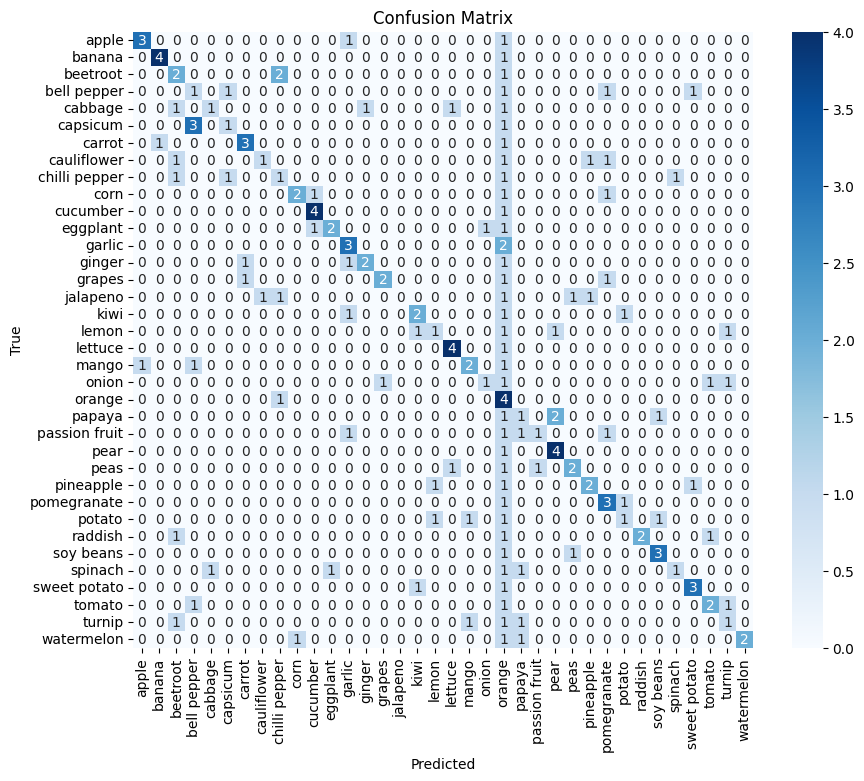

In [6]:
val_generator.reset()
preds = model.predict(val_generator)
y_pred = np.argmax(preds, axis=1)
y_true = val_generator.classes

print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

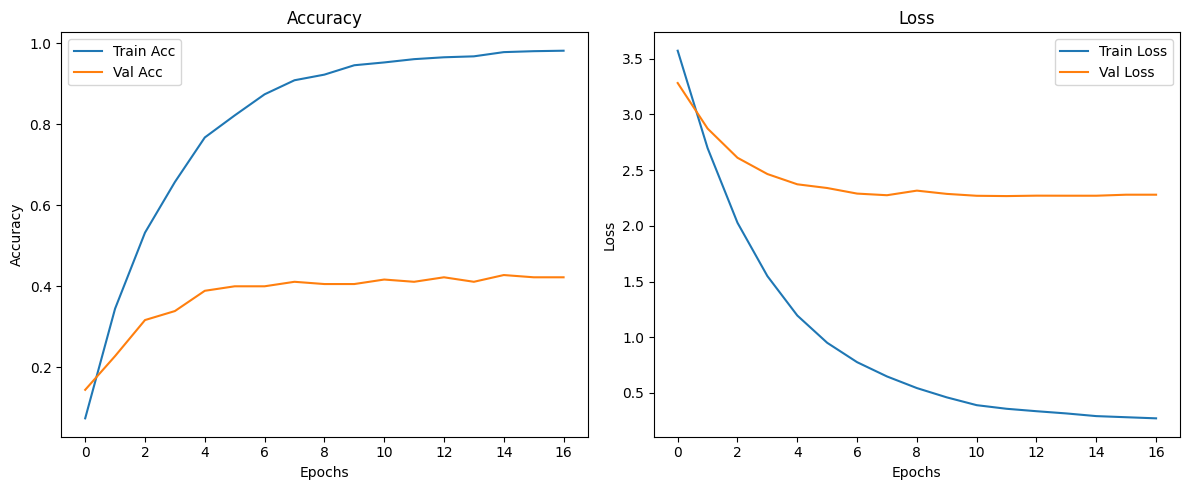

In [7]:
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
